In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 301kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.2MB/s]


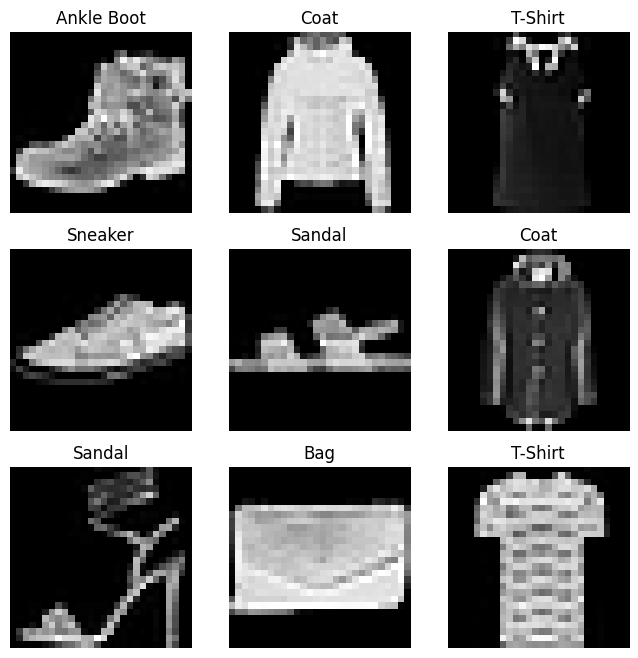

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Creating a Custom Dataset for your files
A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

In the next sections, we’ll break down what’s happening in each of these functions.

In [ ]:
import os
import pandas as pd
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Preparing your data for training with DataLoaders
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Iterate through the DataLoader
We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at Samplers).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


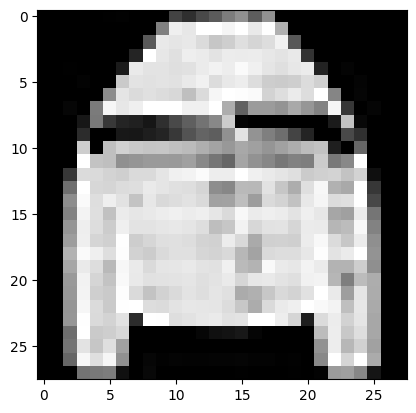

Label: 4


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

📘 The Code
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))


This is typically used in PyTorch, especially when working with image datasets (like MNIST, CIFAR-10, etc.) to one-hot encode class labels.

🔍 Step-by-Step Explanation
1. Lambda(lambda y: ...)

Lambda is from torchvision.transforms and is used to apply a custom transformation to each data point (or target).

Inside it, we define a lambda function that takes one input y — the label (e.g., an integer class index like 3 or 7).

So, this whole thing defines a transformation that takes a label (like 5) and converts it into a one-hot encoded tensor.

2. torch.zeros(10, dtype=torch.float)

Creates a tensor of size 10, filled with zeros.

Example:

torch.zeros(10)
# tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Here, 10 is the number of classes — for example, MNIST has 10 digits (0–9).

3. .scatter_(dim=0, index=torch.tensor(y), value=1)

The scatter_ method fills the tensor at a specific index with a value.

It modifies the tensor in-place (because of the trailing underscore _).

Let’s break it down:

Argument	Meaning
dim=0	We are working along the first (and only) dimension.
index=torch.tensor(y)	The position in the tensor where we want to place the value 1.
value=1	The value to put in that position.

So if y = 3, the code will set the 4th element (index 3) to 1.

🧠 Putting It Together
Example 1

If y = 3:

torch.zeros(10).scatter_(dim=0, index=torch.tensor(3), value=1)


Result:

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

Example 2

If y = 7:

torch.zeros(10).scatter_(dim=0, index=torch.tensor(7), value=1)


Result:

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

✅ Why Use This?

This converts class indices (like 0, 1, 2, …) into one-hot vectors, which are often required by neural networks for:

classification tasks,

certain loss functions (e.g., cross-entropy in some forms),

or to match target shapes with model outputs.

🧩 In Context (Example with a Dataset)
from torchvision.datasets import MNIST
from torchvision.transforms import Lambda

target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float)
                          .scatter_(dim=0, index=torch.tensor(y), value=1))

dataset = MNIST(root='./data', download=True, target_transform=target_transform)


Now, every label in dataset (normally an integer 0–9) will automatically be converted into a one-hot vector.

🧾 Summary
Step	Code	Meaning
1	Lambda(lambda y: ...)	Apply custom transform to target
2	torch.zeros(10)	Create vector of zeros
3	.scatter_(dim=0, index=torch.tensor(y), value=1)	Set the element at position y to 1
✅	Result	One-hot encoded tensor

# Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:
The Train Loop - iterate over the training dataset and try to converge to optimal parameters.

The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

Let’s briefly familiarize ourselves with some of the concepts used in the training loop. Jump ahead to see the Full Implementation of the optimization loop.

# Loss Function

When presented with some training data, our untrained network is likely not to give the correct answer. Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks, and nn.NLLLoss (Negative Log Likelihood) for classification. nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss.

We pass our model’s output logits to nn.CrossEntropyLoss, which will normalize the logits and compute the prediction error.

Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
Inside the training loop, optimization happens in three steps:
Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.

Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

100%|██████████| 26.4M/26.4M [00:03<00:00, 6.88MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 130kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.21MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.7MB/s]


In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [6]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301316  [   64/60000]
loss: 2.287385  [ 6464/60000]
loss: 2.264250  [12864/60000]
loss: 2.257334  [19264/60000]
loss: 2.246161  [25664/60000]
loss: 2.209802  [32064/60000]
loss: 2.224757  [38464/60000]
loss: 2.188622  [44864/60000]
loss: 2.189753  [51264/60000]
loss: 2.143811  [57664/60000]
Test Error: 
 Accuracy: 45.8%, Avg loss: 2.145326 

Epoch 2
-------------------------------
loss: 2.159619  [   64/60000]
loss: 2.146029  [ 6464/60000]
loss: 2.081403  [12864/60000]
loss: 2.102376  [19264/60000]
loss: 2.053956  [25664/60000]
loss: 1.990228  [32064/60000]
loss: 2.021658  [38464/60000]
loss: 1.939738  [44864/60000]
loss: 1.953611  [51264/60000]
loss: 1.872200  [57664/60000]
Test Error: 
 Accuracy: 58.1%, Avg loss: 1.869013 

Epoch 3
-------------------------------
loss: 1.905585  [   64/60000]
loss: 1.868786  [ 6464/60000]
loss: 1.743955  [12864/60000]
loss: 1.795082  [19264/60000]
loss: 1.684510  [25664/60000]
loss: 1.634605  [32064/600

Save and Load the Model

In [ ]:
import torch
import torchvision.models as models

In [ ]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Load the model

To load model weights, you need to create an instance of the same model first, and then load the parameters using load_state_dict() method.

In the code below, we set weights_only=True to limit the functions executed during unpickling to only those necessary for loading weights. Using weights_only=True is considered a best practice when loading weights.

be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.

In [ ]:
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

# Saving and Loading Models with Shapes

When loading model weights, we needed to instantiate the model class first, because the class defines the structure of a network. We might want to save the structure of this class together with the model, in which case we can pass model (and not model.state_dict()) to the saving function:

`torch.save(model, 'model.pth')`

We can then load the model as demonstrated below.

As described in Saving and loading torch.nn.Modules, saving state_dict is considered the best practice. However, below we use weights_only=False because this involves loading the model, which is a legacy use case for torch.save.

`model = torch.load('model.pth', weights_only=False)`

**Note**

This approach uses Python pickle module when serializing the model, thus it relies on the actual class definition to be available when loading the model.